In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
%matplotlib inline
# high-level plots
import seaborn as sns

import statsmodels.api as sm

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
#Gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor


# we use it to interact with the file system
import os
# compute time
from time import time

# Neural network high level framework
import keras
# Sequential is a sequence of blocs
# Input deals with the data fed to the network
from keras.models import Sequential,Input,Model
# Dense is a feedforward layer with fully connected nodes
# Dropout allows to keep part of data, and to "drop out" a the rest
# Flatten makes the data "flat", i.e. in one dimension
from keras.layers import Dense, Dropout, Flatten
# Conv -> convolution, MaxPooling is relative to Pooling
# Activation if the function composing the data in output of a layer
from keras.layers import Conv2D, MaxPooling2D, Activation


from learner.mlearner import learn_with_interactions, learn_without_interactions, sample_random, stepwise_feature_selection
from learner.model import genModelTermsfromString, Model, genModelfromCoeff

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Data

In [2]:
class Data:
    
    def __init__(self):
        
        self.predDimension = "kbs"
        
        # random state , i.e. a seed to split the source and the target datasets
        # by using the same set of configurations for training and testing
        # to sample the source and the target using the same seed
        self.random_state = np.random.randint(0,1000)
        
        
    def mape(self, y_true, y_pred):
        return np.mean(np.abs((y_true-y_pred)/y_true))

    
class UGC_Data(Data):
    
    def __init__(self):
        
        super().__init__()
                
        v_names = ['Gaming_360P-56fe.csv', 'Sports_360P-4545.csv', # grp1
                'Animation_480P-087e.csv', 'CoverSong_360P-5d20.csv', # grp2
                'Lecture_360P-114f.csv', 'MusicVideo_360P-5699.csv', # grp3
                'LiveMusic_360P-1d94.csv', 'LyricVideo_360P-5e87.csv'] # grp4
        
        self.v_names = v_names
        
        # the data folder, see the markdown there for additional explanations
        res_dir = "../../../data/ugc/res_ugc_tiny/"

        # the list of measurements
        # we add each dataset in the list, converting the time to the right format
        # third line asserts that the measures are complete
        self.listVideo = [pd.read_table(res_dir+v, delimiter = ',') for v in v_names]
        
        # a list of features to keep as explicative variables
        self.keep_features = ['cabac', '8x8dct', 'mbtree', 'rc_lookahead', 'analyse', 'me', 'subme', 'mixed_ref', 
                              'me_range', 'qpmax', 'aq-mode', 'trellis','fast_pskip', 'chroma_qp_offset', 
                              'bframes', 'b_pyramid', 'b_adapt', 'direct', 'ref', 'deblock', 'weightb', 'open_gop',
                              'weightp', 'scenecut']

        # ordinal data to convert into dummies
        self.to_dummy_features = ['rc_lookahead', 'analyse', 'me', 'subme', 'mixed_ref', 'me_range', 'qpmax', 
                                  'aq-mode','trellis','fast_pskip', 'chroma_qp_offset', 'bframes', 'b_pyramid', 
                                  'b_adapt', 'direct', 'ref', 'deblock', 'weightb', 'open_gop', 'weightp', 
                                  'scenecut']
        
        ## All the videos
        res_dir = "../../../data/ugc/res_ugc/"
        
        # the list of videos names, e.g. Animation_360P-3e40
        # we sort the list so we keep the same ids between two launches
        complete_v_names = [name for name in sorted(os.listdir(res_dir)) if name not in v_names]
        
        self.complete_listVideo = [pd.read_table(res_dir+v, delimiter = ',') for v in complete_v_names]

        

class ICPE_data(Data):
    
    def __init__(self):
        
        super().__init__()
        
        dataFolderName = './data/'
        
        listVideoName =['deadline_cif', 'bridge_close_cif', '720p50_parkrun_ter', 'akiyo_qcif',
                        'bridge_far_cif', 'sunflower_1080p25', 'sintel_trailer_2k_480p24', 'husky_cif',
                        'netflix', 'waterfall_cif', 'claire_qcif', 'FourPeople_1280x720_60', 'students_cif',
                        'mobile_sif', 'flower_sif', 'riverbed_1080p25', 'blue_sky_1080p25', 'football_cif',
                        'tractor_1080p25', 'football_cif_15fps', 'tennis_sif', 'ducks_take_off_420_720p50',
                        'ice_cif', 'crowd_run_1080p50', 'soccer_4cif']

        # creation of the list of videos (for each video: x264 configurations + measurements)
        listVideo = []

        for vn in listVideoName:
            listVideo.append(pd.read_table(dataFolderName+vn+'/result_mean.csv', 
                                           delimiter = ',',
                                           index_col = 0))
        
        self.listVideo = listVideo
        
        self.complete_listVideo = listVideo
        
        # a list of features to keep as explicative variables
        self.keep_features = ['no_8x8dct', 'no_asm', 'no_cabac', 'no_deblock', 'no_fast_pskip', 'no_mbtree', 
                              'no_mixed_refs', 'no_weightb']

        # ordinal data to convert into dummies
        self.to_dummy_features = ['rc_lookahead', 'ref']

In [3]:
chosen_data = UGC_Data

# TL

## 1. No transfer

In [4]:
class NT(chosen_data):
    
    def __init__(self):
        super().__init__()
    
    def learn(self, target_id, train_size):

        # random state , i.e. a seed to split the source and the target datasets
        # by using the same set of configurations for training and testing
        
        # We define the target video, and split it into train-test
        target = self.listVideo[target_id]
        #print(target.shape)
        #dummies = pd.get_dummies(target[self.keep_features], drop_first = False, columns=self.to_dummy_features)
        #X_tgt = pd.DataFrame(np.array(dummies, dtype=int))
        X_tgt =  pd.get_dummies(target[self.keep_features], drop_first = False)
        y_tgt = target[self.predDimension]
        X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(X_tgt, 
                                                                            y_tgt, 
                                                                            train_size = train_size)
        #print(X_tgt_train.shape)
        lf = RandomForestRegressor()
        lf.fit(X_tgt_train, y_tgt_train)
        y_tgt_pred_test = lf.predict(X_tgt)

        # We return the mean average percentage error 
        # between the real values of y_test from target 
        # and the predictions shifted 
        # return self.mape(y_tgt_test, y_tgt_pred_test)
        return np.argmin(y_tgt_pred_test)

In [5]:
nt = NT()

nt.learn(target_id = 7, train_size = 198)

169

## 2. Beetle

In [6]:
class Beetle(chosen_data):
    
    def __init__(self):
        super().__init__()
        
    def find_bellwether(self, y_tgt_train, train_size):
        
        corr_spearman = []
        
        for source_id in range(100):#len(self.complete_listVideo)):
            
            y_src_train, y_src_test = train_test_split(self.complete_listVideo[source_id][self.predDimension], 
                                           train_size = train_size,
                                           random_state = self.random_state)
            
            corr_spearman.append(sc.spearmanr(y_src_train, y_tgt_train).correlation)
            
        return np.argmax(corr_spearman)
        
    def learn(self, target_id, train_size = 0.7):

        # the percentage (proportion) of configurations used for the test
        # pct_test = 1-nb_config_target_training/len(listVideo[target_id].index)

        # We define the source video, and split it into train-test

        # print(X_src_train.shape)
        # We define the target video, and split it into train-test
        target = self.listVideo[target_id]
        
        X_tgt = pd.get_dummies(target[self.keep_features], drop_first = False)
        y_tgt = target[self.predDimension]
        X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(X_tgt, 
                                                                            y_tgt, 
                                                                            train_size = train_size, 
                                                                            random_state = self.random_state)
        
        source_id = self.find_bellwether(y_tgt_train, train_size)
        # print(source_id)
        
        source = self.complete_listVideo[source_id]
        
        X_src = pd.get_dummies(source[self.keep_features], drop_first = False)
        y_src = source[self.predDimension]
        X_src_train, X_src_test, y_src_train, y_src_test = train_test_split(X_src, 
                                                                            y_src, 
                                                                            train_size = train_size,
                                                                            random_state = self.random_state)
        
        lf = RandomForestRegressor()
        lf.fit(X_src, y_src)
        y_tgt_pred = lf.predict(X_tgt)

        # We return the mean average percentage error 
        # between the real values of y_test from target 
        # and the predictions shifted
        # return self.mape(y_tgt_test, y_tgt_pred_test)
        return np.argmin(y_tgt_pred)

In [7]:
beetle = Beetle()

beetle.learn(target_id = 7, train_size = 10)

104

## 3. Model Shift

In [8]:
class MS(chosen_data):
    
    def __init__(self):
        super().__init__()
    
    def learn(self, source_id, target_id, train_size = 0.7, 
                    learning_algorithm = RandomForestRegressor, shift_function = RandomForestRegressor):
    
        # the percentage (proportion) of configurations used for the test
        # pct_test = 1-nb_config_target_training/len(listVideo[target_id].index)
        
        # We define the source video, and split it into train-test
        source = self.listVideo[source_id]
        #dummies = pd.get_dummies(source[self.keep_features], drop_first = True, columns=self.to_dummy_features)
        #X_src = pd.DataFrame(np.array(dummies, dtype=int))
        X_src = pd.get_dummies(source[self.keep_features], drop_first = False)
        y_src = source[self.predDimension]
        X_src_train, X_src_test, y_src_train, y_src_test = train_test_split(X_src, 
                                                                            y_src, 
                                                                            train_size = train_size,
                                                                            random_state = self.random_state)
        # print(X_src_train.shape)
        # We define the target video, and split it into train-test
        target = self.listVideo[target_id]
        # dummies = pd.get_dummies(target[self.keep_features], drop_first = True, columns=self.to_dummy_features)
        X_tgt = pd.get_dummies(target[self.keep_features], drop_first = False)
        # X_tgt = pd.DataFrame(np.array(dummies, dtype=int))
        y_tgt = target[self.predDimension]
        X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(X_tgt, 
                                                                            y_tgt, 
                                                                            train_size = train_size, 
                                                                            random_state = self.random_state)

        # The learning algorithm, training on the source video
        X_src_train2, _, y_src_train2, _ = train_test_split(X_src, y_src, train_size = 0.9)
        
        lf = learning_algorithm()
        lf.fit(X_src_train2, y_src_train2)
        y_src_pred = np.array(lf.predict(X_src)).reshape(-1,1)

        # The shift function, to transfer the prediction from the source to the target
        shift = shift_function()
        shift.fit(np.array(y_src_train).reshape(-1,1), y_tgt_train)
        y_tgt_pred = shift.predict(y_src_pred)

        # We return the mean average percentage error 
        # between the real values of y_test from target 
        # and the predictions shifted 
        return np.argmin(y_tgt_pred)

In [9]:
nt = MS()

nt.learn(source_id = 1, target_id = 2, train_size = 150)

108

## 4. Learning to Sample

In [10]:
class L2S(chosen_data):
    
    def __init__(self):
        super().__init__()
    
    ### Step 1: Extraction Process of Performance Models
    
    #Select a good model for predicting the performance of the source video
    
    #Original files:
    #https://github.com/cmu-mars/model-learner/blob/tutorial/learner/mlearner.py for the stepwise selection
    #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html for the interactions
    
    # @PooyanJamshidi:
    # We just change slightly some functions from the original repository,
    # mainly because we don't want to add a constant in the model
    # + steps 2 and 3 were implemented in matlab but we did not find them in python
    def stepwise_selection(self, X, y,
                           initial_list = [], 
                           threshold_in = 0.0001, 
                           threshold_out = 0.05, 
                           verbose=False):

        ndim = X.shape[1]
        features = [i for i in range(ndim)]
        included = list(initial_list)

        while True:
            changed=False

            # forward step (removed a constant)
            excluded = list(set(features)-set(included))
            new_pval = pd.Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, pd.DataFrame(X[included+[new_column]])).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add {:30} with p-value {:.5}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, pd.DataFrame(X[included])).fit()
            pvalues = model.pvalues
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed = True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.5}'.format(worst_feature, worst_pval))
            if not changed:
                if verbose:
                    print("Construction of the model completed!")
                break
        return included
    
    ### Step 2: Active Sampling
    
    #### A - ] Exploitation : use the source's prediction model
    
    ##### (i) Sort the coefficients of the previous constructed model
    ##### (ii) Choose the coefficient with the highest value
    ##### (iii) Select the configurations with this feature activated

    # I assumed it was recursive, with a decreasing influence in the selection 
    # for a decreasing importance in the regression.
    
    def select_exploitation(self, df, sc, config_selected):
        
        self.nb_config = int(self.nb_config_exploitation - len(config_selected))
        
        if self.nb_config == 0:
            #print("Done!\n")
            return config_selected

        # if we don't have any important coefficient left to help us choose configs
        # we take the nb_config first configurations
        if len(sc) == 0:
            #print("Selecting " + str(self.nb_config) + " configurations from the rest of the dataset!")
            for conf in df.index[0:self.nb_config]:
                config_selected.append(conf)
            return config_selected

        # otherwise we just use the best coef to choose configs
        else:

            # we choose the best features coef (biggest absolute value)
            most_important_coef = sc[0]

            #print("Feature : " + str(most_important_coef))

            # configs with this feature activated
            imp_index = np.where(df[most_important_coef]==1)[0]

            # number of configs with this feature activated
            nb_imp_index = len(imp_index)

            # if we have more values to choose 
            # than the number of configurations with the best feature activated
            # we add all the configuration to the selected set
            # and we select the rest of the configuration based on other coefficients
            if nb_imp_index <= self.nb_config:
                for conf in df.iloc[imp_index].index:
                    config_selected.append(conf)
                #if nb_imp_index > 0:
                #    print("Added "+str(nb_imp_index)+ " values, "+
                #          str(self.nb_config-nb_imp_index)+" left to choose \n")
                # then we apply recursively this method to the rest of the dataframe
                return self.select_exploitation(df.iloc[np.where(df[most_important_coef]==0)[0]], 
                                              sc[1:len(sc)],
                                              config_selected)

            # otherwise we have enough values with this features activated
            # to select all the remaining configurations
            # so we apply the method to the dataframe containing all the feature activated
            # and we select the configuration by using the followings features
            else:
                return self.select_exploitation(df.iloc[imp_index], 
                                     sc[1:len(sc)], 
                                     config_selected)
    
    
    
    #### B-] Exploration : Select specific configurations, similar between the source and the target
    
    # it selects the group of configurations kept for exploration in one step:
    # if you select config per config, you may choose a local optimal
    
    def select_exploration(self, exploitation_conf, ratio_exploitation, number_group = 10):
        
        nb_exploration = int(np.round(self.config_tot*(1-ratio_exploitation)))

        #target = self.listVideo[id_target]

        # all the config left for exploration
        # total minus those chosen for exploitation
        explor_conf = np.setdiff1d(self.source.index, exploitation_conf)

        # initialization : we take the first nb_exploration config
        best_explor = explor_conf[0:nb_exploration]

        # we group it with the exploitation configurations
        conf = np.concatenate((exploitation_conf, best_explor), axis=0)
        
        # for the moment, it's our best entropy
        best_entropy = sc.entropy(self.target.iloc[conf][self.predDimension], 
                                  self.source.iloc[conf][self.predDimension])

        # then we incrementally select the configurations to diminish the entropy 
        group_counter = 0

        while group_counter < number_group:

            group_counter +=1

            # current group to 'challenge' the best result
            np.random.shuffle(explor_conf)
            current_explor = explor_conf[0:nb_exploration]

            # we group it with the exploitation configurations
            conf = np.concatenate((exploitation_conf, current_explor), axis=0)

            # we compute the Kullback Leibler divergence between the source and the target
            current_entropy = sc.entropy(self.target.iloc[conf][self.predDimension], 
                                         self.source.iloc[conf][self.predDimension])

            # we finally take the group giving the lowest entropy
            # if this group is better than the best group, we replace it by the new one
            if current_entropy > best_entropy:
                #print("Entropy gained : "+str(current_entropy-best_entropy))
                best_entropy = current_entropy
                best_explor = current_explor

        return best_explor
    
    
    def learn(self, source_id, target_id, ratio_exploitation = 0.3, l2s_tr_ratio = 0.8, train_size = 0.7):

        # the source video
        self.source = self.listVideo[source_id]

        # the number of config used in the training
        self.config_tot = int(train_size)
        
        if train_size <= 1:
            self.config_tot = int(train_size*self.source.shape[1])

        # transform some variables into dummies, to fit the orginal paper
        # since we don't want to introduce a meaningless constant in the model, 
        # we have to keep all columns
        dummies = pd.get_dummies(self.source[self.keep_features], drop_first = False)

        X_src = pd.DataFrame(np.array(dummies, dtype=int))

        #X_src = self.source[self.keep_features]
        
        # add interactions
        poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = True)
        X_interact = pd.DataFrame(np.array(poly.fit_transform(X_src), int))

        # performance variable, to predict
        y_src = self.source[self.predDimension]
        
        # we train the model with the training data
        
        # print("\n############### I- Knowledge extraction #################\n")

        selected_features = self.stepwise_selection(X_interact, y_src)

        # print("\n############### II- Sampling #################\n")

        reg = LinearRegression()

        reg.fit(X_interact[selected_features], y_src)

        sorted_coefs = pd.Series(np.abs(reg.coef_), 
                                 selected_features).sort_values(ascending=False).index

        # print("A- EXPLOITATION\n")
        
        self.nb_config_exploitation = int(ratio_exploitation*self.config_tot)
        
        exploitation_conf = self.select_exploitation(X_interact, sorted_coefs, [])
        
        # print(exploitation_conf)

        # print("\nB- EXPLORATION\n")

        # we ensure we sample the configurations of the training set
        # which removes the potential threat of using the configuration of the testing set
        # during the training
        
        # target
        self.target = self.listVideo[target_id]
        
        exploration_conf = self.select_exploration(exploitation_conf, ratio_exploitation)

        sampled_conf = np.concatenate((exploitation_conf,exploration_conf), axis=0)

        #print("\n############### III- Performance Model Learning #################\n")

        # we build a performance model for the target
        # instead of using all the configurations, we use the sampled configuration
        # ie we remove the unnecessary configurations
        # print(len(sampled_conf))

        X_tgt_tr = pd.get_dummies(self.target[self.keep_features],
                                  drop_first = False).iloc[sampled_conf]
        y_tgt_tr = self.target[self.predDimension].iloc[sampled_conf]
        
        X_tgt_te = pd.get_dummies(self.target[self.keep_features], 
                                  drop_first = False).drop(sampled_conf, inplace = False, axis=0)
        y_tgt_te = self.target[self.predDimension].drop(sampled_conf, inplace = False, axis=0)

        # we train the model with the sampled configuration
        lf = RandomForestRegressor()
        lf.fit(X_tgt_tr, y_tgt_tr)
        
        # we predict the performance of all configurations
        y_tgt_pred = lf.predict(X_src)
        
        # we return the best configuration in terms of prediction
        return np.argmin(y_tgt_pred)


In [11]:
l2s = L2S()

l2s.learn(source_id = 1, target_id = 2, train_size = 150)

43

# Comparison 

l2s = L2S()
ms = MS()
nt = NT()

pcts = []
pcts.extend([5,10,20,30,40,50,75,100])
pcts.extend(np.round(np.arange(110, 1110, 100), 2))

#res_l2s = [l2s.learn(source_id = 1, target_id = 2, train_size = pct) for pct in pcts]
res_ms = [ms.learn(source_id = 3, target_id = 2, train_size = pct) for pct in pcts]
res_nt = [nt.learn(target_id = 2, train_size = pct) for pct in pcts]

plt.figure(figsize=(10,5))
#plt.scatter(pcts, res_l2s, color = "red", label = "L2S")
plt.plot(np.log(pcts), res_ms, 'o-', color = "blue", label = "MS")
plt.plot(np.log(pcts), res_nt, 'o-', color = "black", label = "NT")
plt.legend()
plt.show()

Source = 1


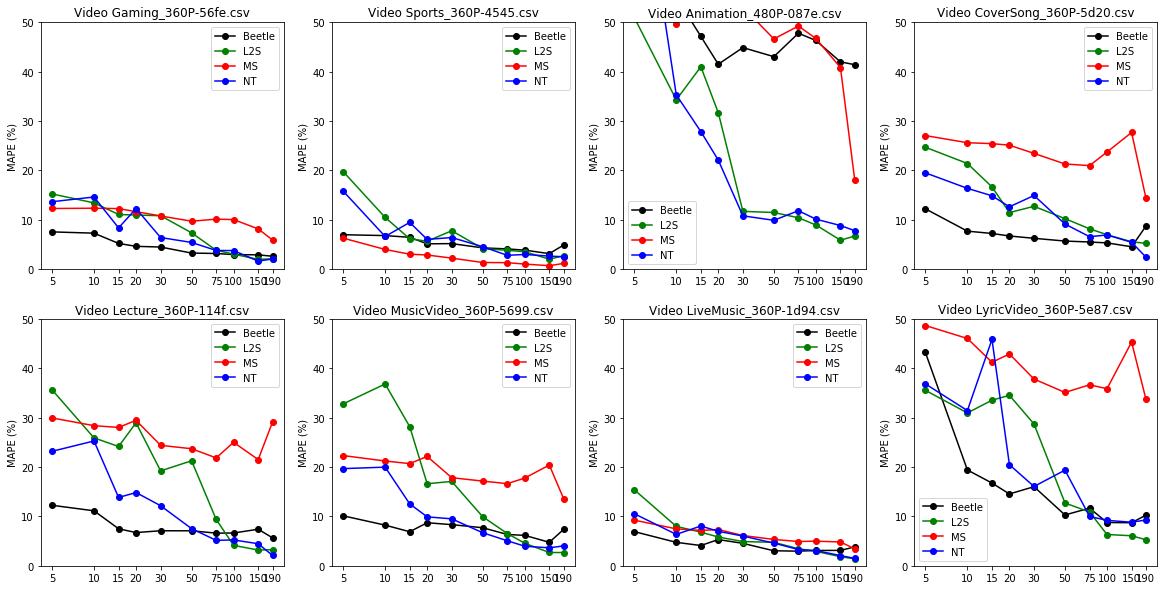

In [13]:
l2s = L2S()
ms = MS()
nt = NT()
beetle = Beetle()

#for j in range(8):

pcts = [5, 10, 15, 20, 30, 50, 75, 100, 150, 190]
    
print("Source = 1")

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2, 4, 8)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.ylim((0,50))
    plt.ylabel('MAPE (%)')
    plt.plot(np.log(pcts), 
             [100*beetle.learn(target_id = i, train_size = pct) for pct in pcts],
             'o-', 
             c='black', 
             label = 'Beetle')
    plt.plot(np.log(pcts), 
             [100*l2s.learn(source_id = 1, target_id = i, train_size = pct) for pct in pcts],
             'o-', 
             c='green', 
             label = 'L2S')
    plt.plot(np.log(pcts), 
             [100*ms.learn(source_id = 1, target_id = i, train_size = pct) for pct in pcts],
             'o-', 
             c='red', 
             label = 'MS')
    plt.plot(np.log(pcts), 
             [100*nt.learn(target_id = i, train_size = pct) for pct in pcts],
             'o-', 
             c='blue', 
             label = 'NT')
    plt.legend()
    plt.title('Video '+str(l2s.v_names[i]))
    plt.savefig("test.png")
    plt.xticks(np.log(pcts), pcts)
plt.show()

In [ ]:
pcts = [5, 10, 15, 20, 30, 50, 75, 100, 150, 190]

In [21]:
l2s = L2S()

l2s_results = [[100*np.mean([l2s.learn(source_id = j, target_id = i, train_size = pct) for j in range(8) if j!=i]) 
                           for pct in pcts] for i in range(8)]

In [14]:
ms = MS()

ms_results = [[100*np.mean([ms.learn(source_id = j, target_id = i, train_size = pct) for j in range(8) if j!=i]) 
                           for pct in pcts] for i in range(8)]

In [16]:
beetle = Beetle()

beetle_results = [[100*beetle.learn(target_id = i, train_size = pct) for pct in pcts] for i in range(8)]

In [18]:
nt = NT()

nt_results = [[100*np.mean([nt.learn(target_id = i, train_size = pct) 
                            for j in range(5)]) for pct in pcts] for i in range(8)]

nt_results

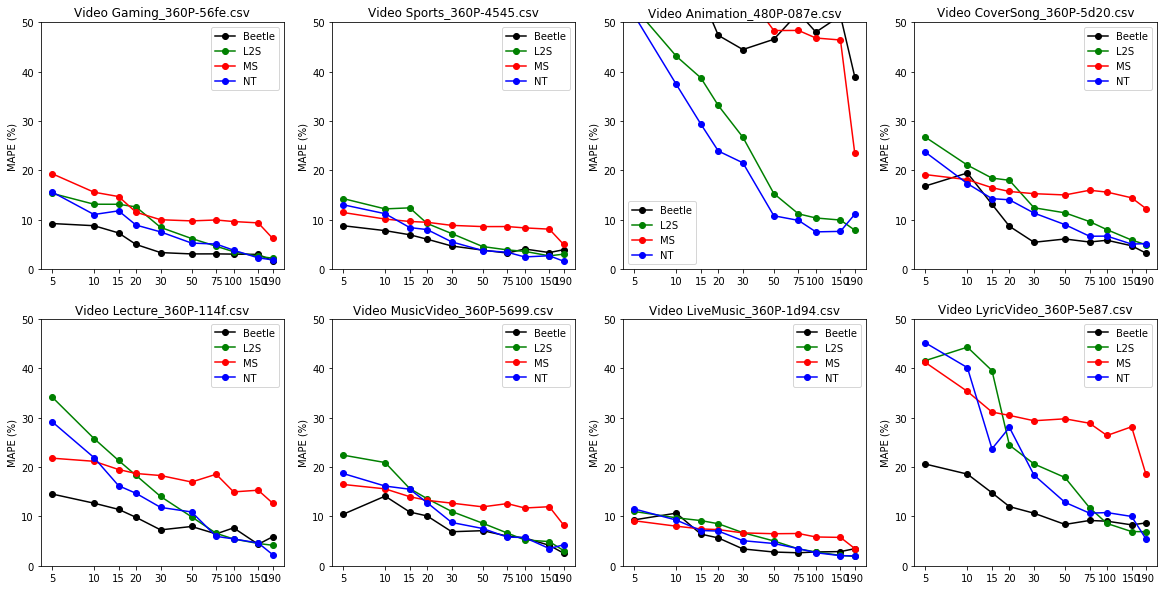

In [22]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2, 4, 8)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.ylim((0,50))
    plt.ylabel('MAPE (%)')
    plt.plot(np.log(pcts), 
             beetle_results[i],
             'o-', 
             c='black', 
             label = 'Beetle')
    plt.plot(np.log(pcts), 
             l2s_results[i],
             'o-', 
             c='green', 
             label = 'L2S')
    plt.plot(np.log(pcts), 
             ms_results[i],
             'o-', 
             c='red', 
             label = 'MS')
    plt.plot(np.log(pcts), 
             nt_results[i], 
             'o-', 
             c='blue', 
             label = 'NT')
    plt.legend()
    plt.title('Video '+str(l2s.v_names[i]))
    plt.savefig("test.png")
    plt.xticks(np.log(pcts), pcts)
plt.show()